In [2]:
import gdown
import zipfile
import os

file_id = "1KCKfyIGbQi8a7bIYta3LM8dFStxVzVX-"
url = f"https://drive.google.com/uc?id={file_id}"
output = "dataset.zip"

gdown.download(url, output, quiet=False)

# Extract
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("dataset")

print("Extracted files:", os.listdir("dataset"))


Downloading...
From (original): https://drive.google.com/uc?id=1KCKfyIGbQi8a7bIYta3LM8dFStxVzVX-
From (redirected): https://drive.google.com/uc?id=1KCKfyIGbQi8a7bIYta3LM8dFStxVzVX-&confirm=t&uuid=f37deeed-376e-4b48-9dd7-5a2d1c9141e7
To: /kaggle/working/dataset.zip
100%|██████████| 1.78G/1.78G [00:14<00:00, 126MB/s] 


Extracted files: ['Shop DataSet']


# PreTrained Model

# Importans & Load Dataset And Labels

In [30]:

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, Dense, Dropout,
    LSTM, Bidirectional, GlobalAveragePooling2D
)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

DATASET_DIR = "/kaggle/working/dataset/Shop DataSet"  
IMG_SIZE = (160, 160)
NUM_FRAMES = 16
BATCH_SIZE = 4
LR_HEAD = 1e-4
LR_FINE = 1e-5
BACKBONE_FINE_TUNE_LAYERS = 20
EPOCHS_HEAD = 25
EPOCHS_FINE = 25

def extract_frames(video_path, num_frames=NUM_FRAMES, target_size=IMG_SIZE):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames // num_frames, 1)
    for i in range(0, total_frames, step):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, target_size)
        frames.append(frame)
        if len(frames) >= num_frames:
            break
    cap.release()

    while len(frames) < num_frames:
        frames.append(frames[-1])
    return np.array(frames)


def load_videos_from_folders(root_dir):
    videos, labels = [], []
    class_names = sorted(os.listdir(root_dir))
    label2id = {cls: idx for idx, cls in enumerate(class_names)}

    for cls in class_names:
        class_path = os.path.join(root_dir, cls)
        for f in os.listdir(class_path):
            if f.endswith(('.mp4', '.avi', '.mov')):
                videos.append(os.path.join(class_path, f))
                labels.append(label2id[cls])

    return videos, np.array(labels), class_names

videos, labels, class_names = load_videos_from_folders(DATASET_DIR)
print(f"Found {len(videos)} videos across {len(class_names)} classes: {class_names}")


Found 855 videos across 2 classes: ['non shop lifters', 'shop lifters']


# Train / Test Split 

In [3]:
from sklearn.model_selection import train_test_split
train_videos, test_videos, train_labels, test_labels = train_test_split(
    videos, labels, test_size=0.2, stratify=labels, random_state=42
)
print(f"Total videos: {len(videos)}")
print(f"Training videos: {len(train_videos)}")
print(f"Testing videos: {len(test_videos)}")


Total videos: 855
Training videos: 684
Testing videos: 171


# Preprocess Frames For MobileNetV2

In [4]:
def preprocess_frames_for_backbone(frames):
    return preprocess_input(frames.astype(np.float32))


# Data Augmentation With Pretrained  MobileNETV2 + LSTM

In [6]:
def augment_video(frames):
    frames = tf.convert_to_tensor(frames, dtype=tf.float32)

    if tf.random.uniform(()) > 0.5:
        frames = tf.image.flip_left_right(frames)

    if tf.random.uniform(()) > 0.5:
        delta = tf.random.uniform([], -0.2, 0.2)
        frames = tf.image.adjust_brightness(frames, delta)

    if tf.random.uniform(()) > 0.5:
        contrast_factor = tf.random.uniform([], 0.8, 1.2)
        frames = tf.image.adjust_contrast(frames, contrast_factor)

    if tf.random.uniform(()) > 0.5:
        crop_frac = tf.random.uniform([], 0.8, 1.0)
        h, w, _ = frames.shape[1:]
        ch, cw = int(h * crop_frac), int(w * crop_frac)
        top = tf.random.uniform([], 0, h - ch, dtype=tf.int32)
        left = tf.random.uniform([], 0, w - cw, dtype=tf.int32)
        frames = frames[:, top:top+ch, left:left+cw, :]
        frames = tf.image.resize(frames, IMG_SIZE)

    return frames.numpy()


def video_generator(video_paths, labels, batch_size=BATCH_SIZE, augment=False):
    while True:
        idx = np.random.permutation(len(video_paths))
        for i in range(0, len(video_paths), batch_size):
            batch_idx = idx[i:i+batch_size]
            batch_videos = []
            batch_labels = []
            for j in batch_idx:
                frames = extract_frames(video_paths[j])
                if augment:
                    frames = augment_video(frames)
                frames = preprocess_frames_for_backbone(frames)
                batch_videos.append(frames)
                batch_labels.append(labels[j])
            yield np.array(batch_videos), tf.keras.utils.to_categorical(batch_labels, num_classes=len(class_names))

train_gen = video_generator(train_videos, train_labels, augment=True)
test_gen = video_generator(test_videos, test_labels, augment=False)

steps_train = len(train_videos) // BATCH_SIZE
steps_val = len(test_videos) // BATCH_SIZE


def cnn_pretrained(img_size=IMG_SIZE):
    base = MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=(*img_size, 3)
    )
    x = GlobalAveragePooling2D()(base.output)
    model = Model(inputs=base.input, outputs=x)
    return model, base

frame_cnn, backbone = cnn_pretrained()

def model(num_classes, backbone_model):
    frame_input = Input(shape=(NUM_FRAMES, *IMG_SIZE, 3))
    x = TimeDistributed(backbone_model)(frame_input)
    x = Bidirectional(LSTM(128, return_sequences=False))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(frame_input, output)

model = model(len(class_names), frame_cnn)
model.summary()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 16, 160, 160,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 1280)       │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │     1,442,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,733,954 (14.24 MB)

 Trainable params: 3,699,842 (14.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

# Frozen Layer & Fine-Tune Top Layers

In [7]:
for layer in backbone.layers:
    layer.trainable = False

model.compile(
    optimizer=Adam(LR_HEAD),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5),
    ModelCheckpoint("mobilenet_lstm_best.h5", save_best_only=True)
]

history1 = model.fit(
    train_gen,
    validation_data=test_gen,
    steps_per_epoch=steps_train,
    validation_steps=steps_val,
    epochs=EPOCHS_HEAD,
    callbacks=callbacks,
    verbose=1
)

#  FINE-TUNE TOP LAYERS

for layer in backbone.layers[-BACKBONE_FINE_TUNE_LAYERS:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(LR_FINE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_gen,
    validation_data=test_gen,
    steps_per_epoch=steps_train,
    validation_steps=steps_val,
    epochs=EPOCHS_FINE,
    callbacks=callbacks,
    verbose=1
)

loss, acc = model.evaluate(test_gen, steps=steps_val)
print(f" Test Accuracy: {acc*100:.2f}%")


model.save("mobilenetv2_lstm_Final_Shoplifting.keras")
print("Model saved successfully.")


Epoch 1/25


I0000 00:00:1760751197.774652  294718 cuda_dnn.cc:529] Loaded cuDNN version 90300


171/171 ━━━━━━━━━━━━━━━━━━━━ 157s 408ms/step - accuracy: 0.5555 - loss: 0.7319 - val_accuracy: 0.8333 - val_loss: 0.4825 - learning_rate: 1.0000e-04
Epoch 2/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 43s 254ms/step - accuracy: 0.6514 - loss: 0.6268 - val_accuracy: 0.9107 - val_loss: 0.4015 - learning_rate: 1.0000e-04
Epoch 3/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 44s 256ms/step - accuracy: 0.6847 - loss: 0.5680 - val_accuracy: 0.8512 - val_loss: 0.3726 - learning_rate: 1.0000e-04
Epoch 4/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 43s 254ms/step - accuracy: 0.6860 - loss: 0.5556 - val_accuracy: 0.8982 - val_loss: 0.3842 - learning_rate: 1.0000e-04
Epoch 5/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 44s 258ms/step - accuracy: 0.7330 - loss: 0.5346 - val_accuracy: 0.9222 - val_loss: 0.3523 - learning_rate: 1.0000e-04
Epoch 6/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 41s 240ms/step - accuracy: 0.7788 - loss: 0.4989 - val_accuracy: 0.8982 - val_loss: 0.2972 - learning_rate: 1.0000e-04
Epoch 7/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 41s 242ms/step -

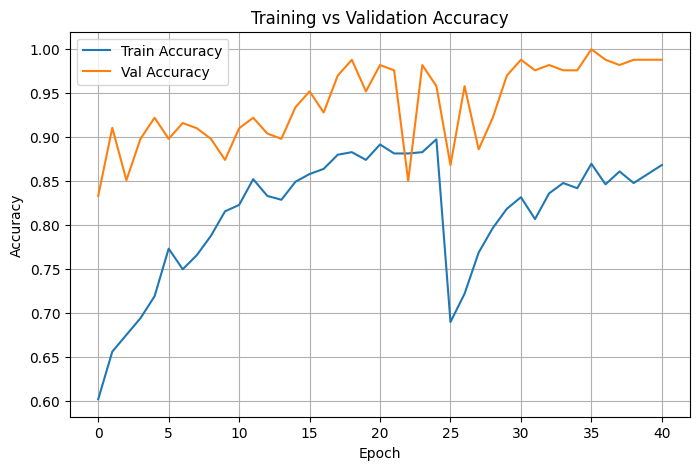

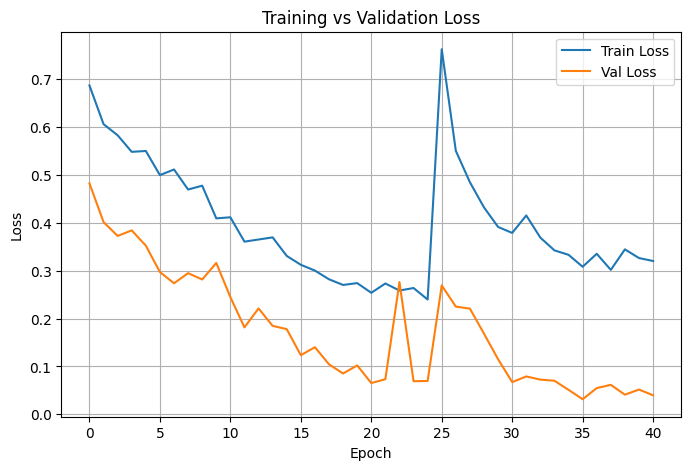

In [8]:
def combine_history(h1, h2):
    history = {}
    for key in h1.history.keys():
        history[key] = h1.history[key] + h2.history.get(key, [])
    return history

full_history = combine_history(history1, history2)

plt.figure(figsize=(8,5))
plt.plot(full_history['accuracy'], label='Train Accuracy')
plt.plot(full_history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(full_history['loss'], label='Train Loss')
plt.plot(full_history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

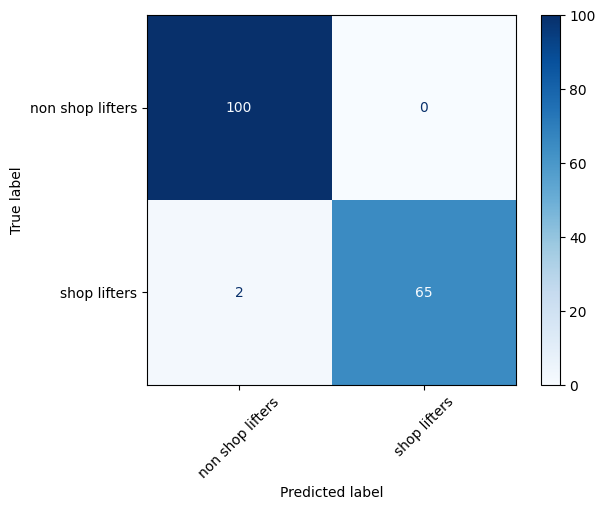

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []
for _ in range(steps_val):
    X, y = next(test_gen)
    preds = model.predict(X)
    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap='Blues', xticks_rotation=45)


# Evaluating model on test data 

In [11]:
print("\n Evaluating model on test data...")
test_loss, test_acc = model.evaluate(test_gen, steps=steps_val, verbose=1)

print("\n Final Evaluation Results:")
print(f" Test Loss: {test_loss:.4f}")
print(f" Test Accuracy: {test_acc * 100:.2f}%")



 Evaluating model on test data...
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.9735 - loss: 0.0651

 Final Evaluation Results:
 Test Loss: 0.0500
 Test Accuracy: 98.80%


In [25]:
y_true = []
y_pred = []

for _ in range(steps_val):
    X_batch, y_batch = next(test_gen)
    preds = model.predict(X_batch)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

report = classification_report(
    y_true, y_pred, target_names=class_names, output_dict=True
)

print(" Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

# Visualization of the Classification Report


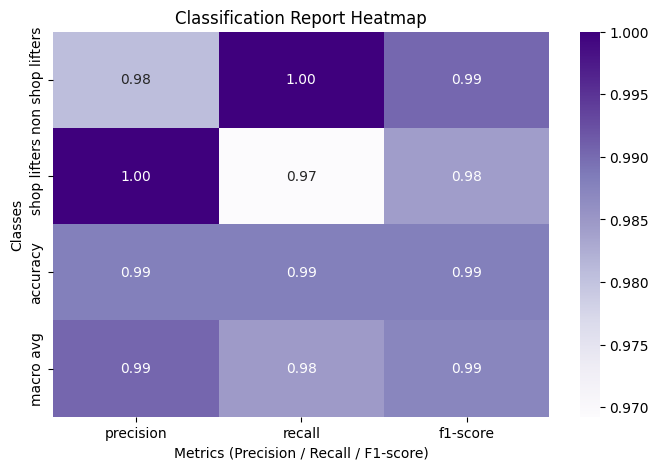

In [28]:
import pandas as pd
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8,5))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Purples")
plt.title("Classification Report Heatmap")
plt.ylabel("Classes")
plt.xlabel("Metrics (Precision / Recall / F1-score)")
plt.show()

# Confusion Matrix


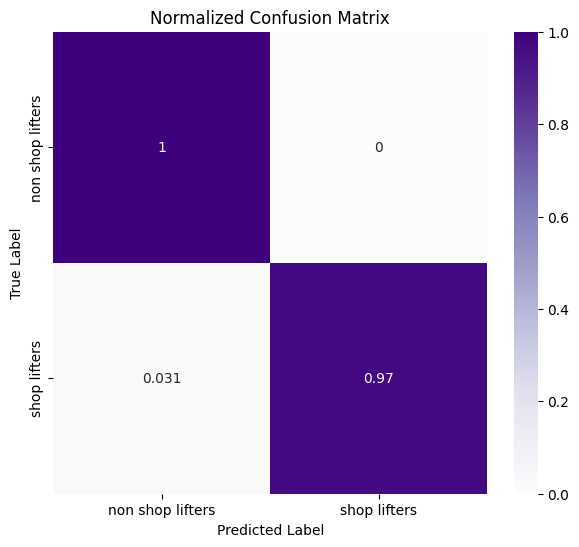

In [27]:
cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, cmap="Purples", xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Visualization the Predection

In [17]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

model = load_model("/kaggle/working/mobilenetv2_lstm_Final_Shoplifting.keras")

IMG_SIZE = (160, 160)
NUM_FRAMES = 16
CLASS_NAMES = ["Normal", "Shoplifting"]  

def extract_frames(video_path, num_frames=NUM_FRAMES):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames // num_frames, 1)

    for i in range(0, total_frames, step):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, IMG_SIZE)
        frames.append(frame)
        if len(frames) >= num_frames:
            break
    cap.release()

    while len(frames) < num_frames:
        frames.append(frames[-1])

    return np.array(frames)


In [14]:
def predict_video(video_path):
    frames = extract_frames(video_path)
    frames = preprocess_input(frames.astype(np.float32))
    pred = model.predict(np.expand_dims(frames, axis=0))[0]
    class_id = np.argmax(pred)
    confidence = pred[class_id]
    return CLASS_NAMES[class_id], confidence


In [15]:
def visualize_prediction(video_path, output_path="output_alert.mp4"):
    label, conf = predict_video(video_path)

    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    alert_color = (0, 255, 0) if label == "Normal" else (0, 0, 255)
    alert_text = f"{label.upper()} ({conf*100:.1f}%)"
    alert_box = f" ALERT: {label.upper()}" if label != "Normal" else " Normal Activity"

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        overlay = frame.copy()
        cv2.rectangle(overlay, (10, 10), (width - 10, 100), alert_color, -1)
        cv2.addWeighted(overlay, 0.4, frame, 0.6, 0, frame)

        # Add text
        cv2.putText(frame, alert_text, (40, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 3)
        cv2.putText(frame, alert_box, (40, height - 40), cv2.FONT_HERSHEY_SIMPLEX, 1, alert_color, 2)

        out.write(frame)

    cap.release()
    out.release()
    print(f" Video saved with overlay: {output_path}")


In [16]:
video_path = "/kaggle/working/dataset/Shop DataSet/non shop lifters/shop_lifter_n_0.mp4"
visualize_prediction(video_path, "predicted_alert.mp4")


1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
 Video saved with overlay: predicted_alert.mp4
